In [2]:
# flake8: noqa: E302

import gzip
import os
import shutil

import requests


def download_and_extract_dataset(url, save_path, folder_path):
    """Download and extract dataset if it doesn't exist."""
    if not os.path.exists(save_path):
        print(f"Downloading {os.path.basename(save_path)}...")
        response = requests.get(url)
        with open(save_path, "wb") as file:
            file.write(response.content)

        decompressed_file_name = os.path.splitext(os.path.basename(save_path))[0]
        decompressed_file_path = os.path.join(folder_path, decompressed_file_name)

        with gzip.open(save_path, "rb") as f_in:
            with open(decompressed_file_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

        print(f"{decompressed_file_name} downloaded and extracted.")
    else:
        print(f"{os.path.basename(save_path)} already exists.")


file_info = [
    (
        "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "train-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "train-labels-idx1-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz",
    ),
]

folder_name = "tmp/mnist"
folder_path = os.path.join(os.getcwd(), folder_name)

os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist

# Download and extract each file
for url, file_name in file_info:
    path_to_save = os.path.join(folder_path, file_name)
    download_and_extract_dataset(url, path_to_save, folder_path)

# %%
import numpy as np


def read_idx3_ubyte_image_file(filename):
    """Read IDX3-ubyte formatted image data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_images = int.from_bytes(f.read(4), byteorder="big")
        num_rows = int.from_bytes(f.read(4), byteorder="big")
        num_cols = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2051:
            raise ValueError(f"Invalid magic number: {magic_num}")

        images = np.zeros((num_images, num_rows, num_cols), dtype=np.uint8)

        for i in range(num_images):
            for r in range(num_rows):
                for c in range(num_cols):
                    pixel = int.from_bytes(f.read(1), byteorder="big")
                    images[i, r, c] = pixel

    return images


def read_idx1_ubyte_label_file(filename):
    """Read IDX1-ubyte formatted label data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_labels = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2049:
            raise ValueError(f"Invalid magic number: {magic_num}")

        labels = np.zeros(num_labels, dtype=np.uint8)

        for i in range(num_labels):
            labels[i] = int.from_bytes(f.read(1), byteorder="big")

    return labels


# Example usage
folder_path = os.path.join(
    os.getcwd(), folder_name
)  # Adjust this path to where you stored the files

train_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "train-images-idx3-ubyte")
)
train_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "train-labels-idx1-ubyte")
)
test_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "t10k-images-idx3-ubyte")
)
test_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "t10k-labels-idx1-ubyte")
)

print(
    f"Shape of train_images: {train_images.shape}"
)  # Should output "Shape of train_images: (60000, 28, 28)"
print(
    f"Shape of train_labels: {train_labels.shape}"
)  # Should output "Shape of train_labels: (60000,)"
print(
    f"Shape of test_images: {test_images.shape}"
)  # Should output "Shape of test_images: (10000, 28, 28)"
print(
    f"Shape of test_labels: {test_labels.shape}"
)  # Should output "Shape of test_labels: (10000,)"

# %%
# Reshape the datasets from 3D to 2D
train_images_2d = train_images.reshape(
    train_images.shape[0], -1
)  # -1 infers the size from the remaining dimensions
test_images_2d = test_images.reshape(test_images.shape[0], -1)

train-images-idx3-ubyte.gz already exists.
train-labels-idx1-ubyte.gz already exists.
t10k-images-idx3-ubyte.gz already exists.
t10k-labels-idx1-ubyte.gz already exists.
Shape of train_images: (60000, 28, 28)
Shape of train_labels: (60000,)
Shape of test_images: (10000, 28, 28)
Shape of test_labels: (10000,)


In [3]:
# conver to pytorch tensors
import torch

train_images_tensor_initial = torch.from_numpy(train_images_2d).float()
train_labels_tensor_initial = torch.from_numpy(train_labels).long()
test_images_tensor = torch.from_numpy(test_images_2d).float()
test_labels_tensor = torch.from_numpy(test_labels).long()

# seed the random number generator
torch.manual_seed(0)

# shuffle the training dataset
indices = torch.randperm(train_images_tensor_initial.shape[0])
train_images_tensor_shuffled = train_images_tensor_initial[indices]
train_labels_tensor_shuffled = train_labels_tensor_initial[indices]

# get a 10% validation set
validation_size = int(train_images_tensor_shuffled.shape[0] * 0.1)
validation_images_tensor = train_images_tensor_shuffled[:validation_size]
validation_labels_tensor = train_labels_tensor_shuffled[:validation_size]
train_images_tensor = train_images_tensor_shuffled[validation_size:]
train_labels_tensor = train_labels_tensor_shuffled[validation_size:]

In [4]:
print(train_labels_tensor.shape)
print(validation_labels_tensor.shape)
print(train_labels_tensor_initial.shape)
print(train_labels_tensor_shuffled.shape)
print(validation_size)

torch.Size([54000])
torch.Size([6000])
torch.Size([60000])
torch.Size([60000])
6000


In [5]:
print("Initial training labels size:", train_labels_tensor_initial.shape[0])
print("Validation set size:", validation_size)
print("Validation labels size after split:", validation_labels_tensor.shape[0])
print("Training labels size after split:", train_labels_tensor.shape[0])

Initial training labels size: 60000
Validation set size: 6000
Validation labels size after split: 6000
Training labels size after split: 54000


## Plot an image

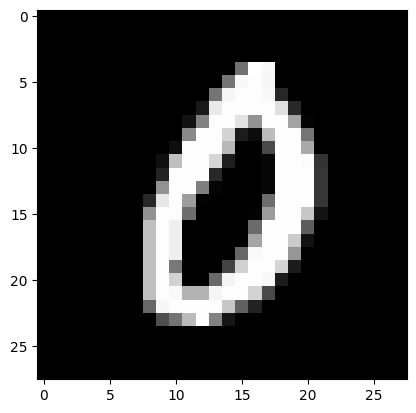

Image shape torch.Size([28, 28])
Label tensor(0)


In [6]:
image_id = 0

image = train_images_tensor[image_id].reshape(28, 28)

import matplotlib.pyplot as plt

plt.imshow(image, cmap="gray")
plt.show()

print("Image shape", image.shape)

print("Label", train_labels_tensor[image_id])

## Get a bounding box of the image

In [7]:
import numpy as np


def get_bounding_box(img):
    """
    Extract the bounding box from an MNIST image.

    Args:
        img (np.ndarray): 2D numpy array representing the MNIST image.

    Returns:
        (np.ndarray): Cropped image with the bounding box.
    """

    # convert torch image to numpy array
    img = img.numpy()

    # Find the rows and columns where the image has non-zero pixels
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)

    # Find the first and last row and column indices where the image has non-zero pixels
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Return the cropped image
    return img[rmin : rmax + 1, cmin : cmax + 1]

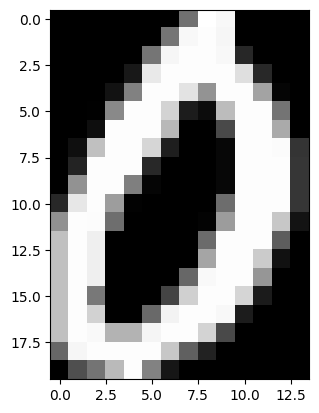

Image shape (20, 14)
Label tensor(0)


In [8]:
image = train_images_tensor[image_id].reshape(28, 28)
cropped_image = get_bounding_box(image)

plt.imshow(cropped_image, cmap="gray")
plt.show()

print("Image shape", cropped_image.shape)

print("Label", train_labels_tensor[image_id])

## Make the image quadratic (20x20)

In [9]:
import cv2

cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
resized_image = cv2.resize(cropped_image_uint8, (20, 20), interpolation=cv2.INTER_AREA)

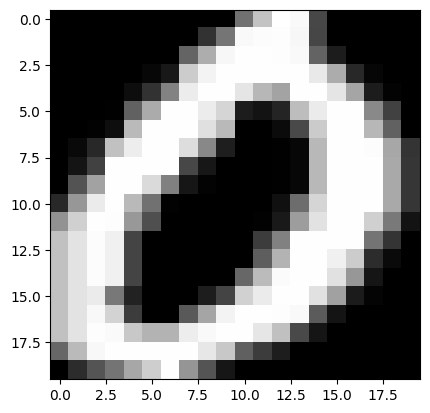

Image shape (20, 20)
Label tensor(0)


In [10]:
plt.imshow(resized_image, cmap="gray")
plt.show()

print("Image shape", resized_image.shape)

print("Label", train_labels_tensor[image_id])

## Create a reshaped image dataset

In [11]:
num_train = len(train_images_tensor)

train_images_tensor_resized = np.zeros((num_train, 400))

for i in range(num_train):
    cropped_image = get_bounding_box(train_images_tensor[i].reshape(28, 28))
    cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
    resized_image = cv2.resize(
        cropped_image_uint8, (20, 20), interpolation=cv2.INTER_AREA
    )
    train_images_tensor_resized[i, :] = resized_image.flatten()

num_test = len(test_images_tensor)

num_val = len(validation_images_tensor)

validation_images_tensor_resized = np.zeros((num_val, 400))

for i in range(num_val):
    cropped_image = get_bounding_box(validation_images_tensor[i].reshape(28, 28))
    cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
    resized_image = cv2.resize(
        cropped_image_uint8, (20, 20), interpolation=cv2.INTER_AREA
    )
    validation_images_tensor_resized[i, :] = resized_image.flatten()

num_test = len(test_images_tensor)

test_images_tensor_resized = np.zeros((num_test, 400))

for i in range(num_test):
    cropped_image = get_bounding_box(test_images_tensor[i].reshape(28, 28))
    cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
    resized_image = cv2.resize(
        cropped_image_uint8, (20, 20), interpolation=cv2.INTER_AREA
    )
    test_images_tensor_resized[i, :] = resized_image.flatten()

## Normalize all datasets

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_normalized = torch.tensor(scaler.fit_transform(train_images_tensor))
val_features_normalized = torch.tensor(scaler.transform(validation_images_tensor))
test_features_normalized = torch.tensor(scaler.transform(test_images_tensor))

train_features_resized_normalized = torch.tensor(
    scaler.fit_transform(train_images_tensor_resized)
)
val_features_resized_normalized = torch.tensor(
    scaler.transform(validation_images_tensor_resized)
)
test_features_resized_normalized = torch.tensor(
    scaler.transform(test_images_tensor_resized)
)

In [13]:
train_features_normalized = train_features_normalized.float()
val_features_normalized = val_features_normalized.float()
test_features_normalized = test_features_normalized.float()

train_features_resized_normalized = train_features_resized_normalized.float()
val_features_resized_normalized = val_features_resized_normalized.float()
test_features_resized_normalized = test_features_resized_normalized.float()

## Try out a medium-sized neural network

In [14]:
# define code to measure accuracy

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score


def evaluate_model(model, resized=False):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        if not resized:
            test_outputs = model(test_features_normalized)
        else:
            test_outputs = model(test_features_resized_normalized)
        _, predicted = torch.max(test_outputs.data, 1)
        accuracy = accuracy_score(test_labels, predicted.numpy())
        print("Accuracy:", accuracy)
        return accuracy

In [15]:
# Define the PyTorch neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Hyperparameters
input_dim = train_features_normalized.shape[1]
hidden_dim = 360
output_dim = len(set(train_labels))  # Assuming train_labels are class indices

# Instantiate the model
model_medium = SimpleNN(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_medium.parameters(), lr=0.001)

# Training loop with L1 regularization
lambda_l1 = 0.0001  # L1 regularization coefficient

validation_losses = []
epoch = 0

model_states = []

while True:
    optimizer.zero_grad()
    outputs = model_medium(train_features_normalized)

    loss = criterion(outputs, train_labels_tensor)

    # Add L1 regularization
    l1_reg = torch.tensor(0.0, requires_grad=True)
    for param in model_medium.parameters():
        l1_reg = l1_reg + torch.norm(param, 1)
    loss += lambda_l1 * l1_reg

    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(
            f"Epoch [{epoch + 1}], Loss: {loss.item():.4f}, validation loss: {validation_losses[-1]:.4f}"
        )

    # store model state
    model_states.append(model_medium.state_dict())

    # Compute validation loss
    with torch.no_grad():
        outputs = model_medium(val_features_normalized)
        loss = criterion(outputs, validation_labels_tensor)
        validation_losses.append(loss.item())

    # Check for early stopping if no improvement in validation loss in last 10 epochs
    if epoch > 10 and validation_losses[-1] > validation_losses[-10]:
        print("Early stopping")
        break

    epoch += 1

best_model_state = model_states[np.argmin(validation_losses)]
model_medium.load_state_dict(best_model_state)

evaluate_model(model_medium)

Epoch [100], Loss: 0.3660, validation loss: 0.1789
Epoch [200], Loss: 0.2531, validation loss: 0.1344
Epoch [300], Loss: 0.2079, validation loss: 0.1109
Epoch [400], Loss: 0.1819, validation loss: 0.0982
Epoch [500], Loss: 0.1642, validation loss: 0.0911
Epoch [600], Loss: 0.1512, validation loss: 0.0869
Epoch [700], Loss: 0.1409, validation loss: 0.0841
Epoch [800], Loss: 0.1327, validation loss: 0.0821
Epoch [900], Loss: 0.1259, validation loss: 0.0808
Early stopping
Accuracy: 0.979


0.979

In [16]:
# Define the deeper PyTorch neural network
class SimpleNN_deep(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(SimpleNN_deep, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Hyperparameters
input_dim = train_features_normalized.shape[1]
output_dim = len(set(train_labels))  # Assuming train_labels are class indices

# Instantiate the model
model_deep = SimpleNN_deep(
    input_dim=input_dim, hidden_dim1=360, hidden_dim2=180, output_dim=output_dim
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_deep.parameters(), lr=0.001)

# Training loop with L1 regularization
lambda_l1 = 0.0001  # L1 regularization coefficient

validation_losses = []
epoch = 0

model_states = []

while True:
    optimizer.zero_grad()
    outputs = model_deep(train_features_normalized)

    loss = criterion(outputs, train_labels_tensor)

    # Add L1 regularization
    l1_reg = torch.tensor(0.0, requires_grad=True)
    for param in model_deep.parameters():
        l1_reg = l1_reg + torch.norm(param, 1)
    loss += lambda_l1 * l1_reg

    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(
            f"Epoch [{epoch + 1}], Loss: {loss.item():.4f}, validation loss: {validation_losses[-1]:.4f}"
        )

    # store model state
    model_states.append(model_deep.state_dict())

    # Compute validation loss
    with torch.no_grad():
        outputs = model_deep(val_features_normalized)
        loss = criterion(outputs, validation_labels_tensor)
        validation_losses.append(loss.item())

    # Check for early stopping if no improvement in validation loss in last 10 epochs
    if epoch > 10 and validation_losses[-1] > validation_losses[-10]:
        print("Early stopping")
        break

    epoch += 1

best_model_state = model_states[np.argmin(validation_losses)]
model_deep.load_state_dict(best_model_state)

evaluate_model(model_deep)

Epoch [100], Loss: 0.4016, validation loss: 0.1481
Epoch [200], Loss: 0.2562, validation loss: 0.0993
Epoch [300], Loss: 0.1861, validation loss: 0.0858
Epoch [400], Loss: 0.1451, validation loss: 0.0830
Early stopping
Accuracy: 0.9794


0.9794

## Let's prune the networks

In [17]:
import copy

from helper import prune_pytorch_network

model_medium_pruned = copy.deepcopy(model_medium)
model_medium_pruned = prune_pytorch_network(model_medium_pruned, 5e-2, 5e-2)

evaluate_model(model_medium_pruned)

Number of weight parameters: 285840
Number of changed weight parameters: 280334
Number of bias parameters: 370
Number of changed bias parameters: 334
Percentage of weights pruned: 98.07%
Percentage of biases pruned: 90.27%
Remaining number of non-zero weights: 5506
Remaining number of non-zero biases: 36
Accuracy: 0.9757


0.9757

In [18]:
model_deep_pruned = copy.deepcopy(model_deep)
model_deep_pruned = prune_pytorch_network(model_deep_pruned, 5e-2, 5e-2)

evaluate_model(model_deep_pruned)

Number of weight parameters: 348840
Number of changed weight parameters: 341472
Number of bias parameters: 550
Number of changed bias parameters: 507
Percentage of weights pruned: 97.89%
Percentage of biases pruned: 92.18%
Remaining number of non-zero weights: 7368
Remaining number of non-zero biases: 43
Accuracy: 0.968


0.968

## Let's try the resized images

In [19]:
# Hyperparameters
input_dim = train_features_resized_normalized.shape[1]
hidden_dim = 205
output_dim = len(set(train_labels))  # Assuming train_labels are class indices

# Instantiate the model
model_medium_resized_dataset = SimpleNN(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_medium_resized_dataset.parameters(), lr=0.001)

# Training loop with L1 regularization
lambda_l1 = 0.0001  # L1 regularization coefficient

validation_losses = []
epoch = 0

model_states = []

while True:
    optimizer.zero_grad()
    outputs = model_medium_resized_dataset(train_features_resized_normalized)

    loss = criterion(outputs, train_labels_tensor)

    # Add L1 regularization
    l1_reg = torch.tensor(0.0, requires_grad=True)
    for param in model_medium_resized_dataset.parameters():
        l1_reg = l1_reg + torch.norm(param, 1)
    loss += lambda_l1 * l1_reg

    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(
            f"Epoch [{epoch + 1}], Loss: {loss.item():.4f}, validation loss: {validation_losses[-1]:.4f}"
        )

    # store model state
    model_states.append(model_medium_resized_dataset.state_dict())

    # Compute validation loss
    with torch.no_grad():
        outputs = model_medium_resized_dataset(val_features_resized_normalized)
        loss = criterion(outputs, validation_labels_tensor)
        validation_losses.append(loss.item())

    # Check for early stopping if no improvement in validation loss in last 10 epochs
    if epoch > 10 and validation_losses[-1] > validation_losses[-10]:
        print("Early stopping")
        break

    epoch += 1

best_model_state = model_states[np.argmin(validation_losses)]
model_medium_resized_dataset.load_state_dict(best_model_state)

evaluate_model(model_medium_resized_dataset, resized=True)

Epoch [100], Loss: 0.3491, validation loss: 0.1727
Epoch [200], Loss: 0.2511, validation loss: 0.1289
Epoch [300], Loss: 0.2029, validation loss: 0.1054
Epoch [400], Loss: 0.1755, validation loss: 0.0912
Epoch [500], Loss: 0.1580, validation loss: 0.0822
Epoch [600], Loss: 0.1459, validation loss: 0.0763
Epoch [700], Loss: 0.1367, validation loss: 0.0725
Epoch [800], Loss: 0.1293, validation loss: 0.0698
Epoch [900], Loss: 0.1233, validation loss: 0.0681
Epoch [1000], Loss: 0.1182, validation loss: 0.0666
Epoch [1100], Loss: 0.1139, validation loss: 0.0653
Epoch [1200], Loss: 0.1103, validation loss: 0.0644
Early stopping
Accuracy: 0.9815


0.9815

In [20]:
model_medium_resized_dataset_pruned = copy.deepcopy(model_medium_resized_dataset)
model_medium_resized_dataset_pruned = prune_pytorch_network(
    model_medium_resized_dataset_pruned, 5e-2, 5e-2
)

evaluate_model(model_medium_resized_dataset_pruned, resized=True)

Number of weight parameters: 84050
Number of changed weight parameters: 79204
Number of bias parameters: 215
Number of changed bias parameters: 186
Percentage of weights pruned: 94.23%
Percentage of biases pruned: 86.51%
Remaining number of non-zero weights: 4846
Remaining number of non-zero biases: 29
Accuracy: 0.9771


0.9771

## Look into haar features

In [21]:
def compute_haar_features(image):
    if image.shape != (20, 20) and image.shape != (28, 28):
        raise ValueError("Input image must be of shape 20x20 or 28x28.")

    features = []

    # Sliding window
    for i in range(0, image.shape[0], 3):  # Slide vertically with a step of 3
        for j in range(0, image.shape[0], 3):  # Slide horizontally with a step of 3

            if i + 6 > image.shape[0] or j + 6 > image.shape[0]:
                continue

            # Extract 6x6 window
            window = image[i : i + 6, j : j + 6]

            # Horizontal feature
            horizontal_feature_value = np.sum(window[0:3, :]) - np.sum(window[3:6, :])

            # Vertical feature
            vertical_feature_value = np.sum(window[:, 0:3]) - np.sum(window[:, 3:6])

            features.append(horizontal_feature_value)
            features.append(vertical_feature_value)

    return np.array(features)

In [22]:
haar_1 = compute_haar_features(train_images_tensor[0].reshape(28, 28).numpy())
print(haar_1)
len_haar_features = len(haar_1)
print("length of a haar feature for 28x28 images", len_haar_features)

[    0.     0.     0.     0.     0.     0.  -117.  -117. -1480. -1246.
 -1363.  1363.     0.     0.     0.     0.     0.     0.     0.     0.
   -18.   -18. -1409. -1607. -2169. -1879. -1502.  2780.  -724.   724.
     0.     0.     0.     0.     0.     0.  -847.  -883. -1244. -2530.
  1435.   963.   501.  -329. -1384.  2726.   -53.    53.     0.     0.
   -41.   -41. -1010. -2658.   508.   366.  1663.  1901.   -36. -3900.
  -331.  4117.  -109.   215.     0.     0.  -488.  -570.  -253. -2863.
   663.  3005.  -386.  -632.  -314. -2994.   643.  3873.   143.   181.
     0.     0.   -47. -1105.   224. -1822.  -145.  2511. -1552. -2594.
   -30.   562.  1125.  2429.    19.    19.     0.     0.   281.  -871.
  -205. -2271. -1857.   939.    35.  -537.  2077.  2069.   671.   671.
     0.     0.     0.     0.   295.  -295.  2109. -1519.  3601.    27.
  2454.  1120.   667.   667.     0.     0.     0.     0.]
length of a haar feature for 28x28 images 128


In [23]:
haar_1 = compute_haar_features(train_images_tensor_resized[0].reshape(20, 20))
print(haar_1)
len_haar_features_resized = len(haar_1)
print("length of a haar feature for 20x20 images", len_haar_features_resized)

[ -339.  -339. -1844. -1810. -1511. -1207.  -131.  -249. -1376.  2298.
 -1690. -2094. -1410. -1280.  1610.  1616.  2663.  -639.   271.  -949.
 -1000. -2236.  1667.  1809.  1742.  1622.   -53. -1387.  -292. -2832.
    98.   608.   988.  2522.  -288.  -292. -1582. -2562.  -412.  -726.
  -110.  2028. -1076.  1026. -2496. -1492. -1082. -1242.  1760.  1966.]
length of a haar feature for 20x20 images 50


## Further simple features

In [24]:
def aspect_ratio(image, threshold=0.5):
    # Threshold the image to create a binary representation
    bin_image = image > threshold
    # Find the bounding box
    row_indices, col_indices = np.nonzero(bin_image)
    max_row, min_row = np.max(row_indices), np.min(row_indices)
    max_col, min_col = np.max(col_indices), np.min(col_indices)

    # Calculate the aspect ratio of the bounding box
    width = max_col - min_col + 1
    height = max_row - min_row + 1

    if height == 0:  # To avoid division by zero
        return 1.0

    return width / height


from scipy.ndimage import label


def num_regions_below_threshold(image, threshold=0.5):
    # Threshold the image so that pixels below the threshold are set to 1
    # and those above the threshold are set to 0.
    bin_image = image < threshold

    # Use connected components labeling
    labeled_array, num_features = label(bin_image)

    # Return the number of unique regions
    # (subtracting 1 as one of the labels will be the background)
    return num_features

In [25]:
# compute datasets

aspect_ratio_train = np.zeros(num_train)
aspect_ratio_val = np.zeros(num_val)
aspect_ratio_test = np.zeros(num_test)

num_white_regions_train = np.zeros(num_train)
num_white_regions_val = np.zeros(num_val)
num_white_regions_test = np.zeros(num_test)

for i in range(num_train):
    aspect_ratio_train[i] = aspect_ratio(train_images_tensor[i].reshape(28, 28).numpy())
    num_white_regions_train[i] = num_regions_below_threshold(
        train_images_tensor[i].reshape(28, 28)
    )

for i in range(num_val):
    aspect_ratio_val[i] = aspect_ratio(
        validation_images_tensor[i].reshape(28, 28).numpy()
    )
    num_white_regions_val[i] = num_regions_below_threshold(
        validation_images_tensor[i].reshape(28, 28)
    )

for i in range(num_test):
    aspect_ratio_test[i] = aspect_ratio(test_images_tensor[i].reshape(28, 28).numpy())
    num_white_regions_test[i] = num_regions_below_threshold(
        test_images_tensor[i].reshape(28, 28)
    )

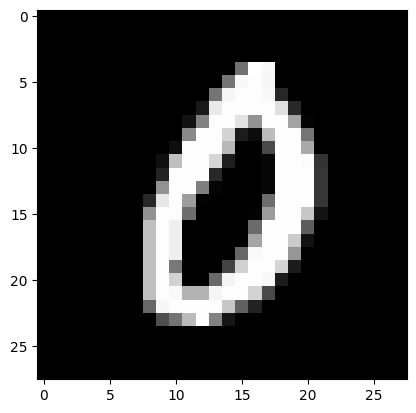

Image shape torch.Size([28, 28])
Label tensor(0)
Aspect ratio 0.7
Number of black regions 2.0


In [26]:
image_id = 0

image = train_images_tensor[image_id].reshape(28, 28)

import matplotlib.pyplot as plt

plt.imshow(image, cmap="gray")
plt.show()

print("Image shape", image.shape)

print("Label", train_labels_tensor[image_id])
print("Aspect ratio", aspect_ratio_train[image_id])
print("Number of black regions", num_white_regions_train[image_id])

In [27]:
# compute datasets

features_train = np.zeros((num_train, len_haar_features + 2))
features_val = np.zeros((num_val, len_haar_features + 2))
features_test = np.zeros((num_test, len_haar_features + 2))

features_train_resized = np.zeros((num_train, len_haar_features_resized + 2))
features_val_resized = np.zeros((num_val, len_haar_features_resized + 2))
features_test_resized = np.zeros((num_test, len_haar_features_resized + 2))

for i in range(num_train):
    haar_features = compute_haar_features(
        train_images_tensor[i].reshape(28, 28).numpy()
    )
    features_train[i, :] = np.hstack(
        (haar_features, aspect_ratio_train[i], num_white_regions_train[i])
    )

for i in range(num_val):
    haar_features = compute_haar_features(
        validation_images_tensor[i].reshape(28, 28).numpy()
    )
    features_val[i, :] = np.hstack(
        (haar_features, aspect_ratio_val[i], num_white_regions_val[i])
    )

for i in range(num_test):
    haar_features = compute_haar_features(test_images_tensor[i].reshape(28, 28).numpy())
    features_test[i, :] = np.hstack(
        (haar_features, aspect_ratio_test[i], num_white_regions_test[i])
    )

for i in range(num_train):
    haar_features = compute_haar_features(
        train_images_tensor_resized[i].reshape(20, 20)
    )
    features_train_resized[i, :] = np.hstack(
        (haar_features, aspect_ratio_train[i], num_white_regions_train[i])
    )

for i in range(num_val):
    haar_features = compute_haar_features(
        validation_images_tensor_resized[i].reshape(20, 20)
    )
    features_val_resized[i, :] = np.hstack(
        (haar_features, aspect_ratio_val[i], num_white_regions_val[i])
    )

for i in range(num_test):
    haar_features = compute_haar_features(test_images_tensor_resized[i].reshape(20, 20))
    features_test_resized[i, :] = np.hstack(
        (haar_features, aspect_ratio_test[i], num_white_regions_test[i])
    )

In [28]:
train_features_normalized = torch.tensor(scaler.fit_transform(features_train))
val_features_normalized = torch.tensor(scaler.transform(features_val))
test_features_normalized = torch.tensor(scaler.transform(features_test))

train_features_resized_normalized = torch.tensor(
    scaler.fit_transform(features_train_resized)
)
val_features_resized_normalized = torch.tensor(scaler.transform(features_val_resized))
test_features_resized_normalized = torch.tensor(scaler.transform(features_test_resized))

In [29]:
train_features_normalized = train_features_normalized.float()
val_features_normalized = val_features_normalized.float()
test_features_normalized = test_features_normalized.float()

train_features_resized_normalized = train_features_resized_normalized.float()
val_features_resized_normalized = val_features_resized_normalized.float()
test_features_resized_normalized = test_features_resized_normalized.float()

## Try out a neural network, on the new 28x28 dataset

In [30]:
# Hyperparameters
input_dim = train_features_normalized.shape[1]
output_dim = len(set(train_labels))  # Assuming train_labels are class indices
hidden_dim = int((input_dim + output_dim) / 2)

# Instantiate the model
model_medium2 = SimpleNN(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_medium2.parameters(), lr=0.001)

# Training loop with L1 regularization
lambda_l1 = 0.0001  # L1 regularization coefficient

validation_losses = []
epoch = 0

model_states = []

while True:
    optimizer.zero_grad()
    outputs = model_medium2(train_features_normalized)

    loss = criterion(outputs, train_labels_tensor)

    # Add L1 regularization
    l1_reg = torch.tensor(0.0, requires_grad=True)
    for param in model_medium2.parameters():
        l1_reg = l1_reg + torch.norm(param, 1)
    loss += lambda_l1 * l1_reg

    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(
            f"Epoch [{epoch + 1}], Loss: {loss.item():.4f}, validation loss: {validation_losses[-1]:.4f}"
        )

    # store model state
    model_states.append(model_medium2.state_dict())

    # Compute validation loss
    with torch.no_grad():
        outputs = model_medium2(val_features_normalized)
        loss = criterion(outputs, validation_labels_tensor)
        validation_losses.append(loss.item())

    # Check for early stopping if no improvement in validation loss in last 10 epochs
    if epoch > 10 and validation_losses[-1] > validation_losses[-10]:
        print("Early stopping")
        break

    epoch += 1

best_model_state = model_states[np.argmin(validation_losses)]
model_medium2.load_state_dict(best_model_state)

evaluate_model(model_medium2)

Epoch [100], Loss: 0.4394, validation loss: 0.3833
Epoch [200], Loss: 0.2931, validation loss: 0.2341
Epoch [300], Loss: 0.2426, validation loss: 0.1850
Epoch [400], Loss: 0.2139, validation loss: 0.1595
Epoch [500], Loss: 0.1948, validation loss: 0.1425
Epoch [600], Loss: 0.1805, validation loss: 0.1301
Epoch [700], Loss: 0.1693, validation loss: 0.1207
Epoch [800], Loss: 0.1602, validation loss: 0.1133
Epoch [900], Loss: 0.1527, validation loss: 0.1074
Epoch [1000], Loss: 0.1465, validation loss: 0.1029
Epoch [1100], Loss: 0.1413, validation loss: 0.0997
Epoch [1200], Loss: 0.1368, validation loss: 0.0970
Epoch [1300], Loss: 0.1329, validation loss: 0.0945
Epoch [1400], Loss: 0.1295, validation loss: 0.0921
Epoch [1500], Loss: 0.1265, validation loss: 0.0902
Epoch [1600], Loss: 0.1238, validation loss: 0.0884
Epoch [1700], Loss: 0.1214, validation loss: 0.0870
Epoch [1800], Loss: 0.1193, validation loss: 0.0859
Epoch [1900], Loss: 0.1174, validation loss: 0.0849
Epoch [2000], Loss: 0

0.9785

In [31]:
model_medium2_pruned = copy.deepcopy(model_medium2)
model_medium2_pruned = prune_pytorch_network(model_medium2_pruned, 1e-1, 1e-1)

evaluate_model(model_medium2_pruned)

Number of weight parameters: 9800
Number of changed weight parameters: 7953
Number of bias parameters: 80
Number of changed bias parameters: 49
Percentage of weights pruned: 81.15%
Percentage of biases pruned: 61.25%
Remaining number of non-zero weights: 1847
Remaining number of non-zero biases: 31
Accuracy: 0.9745


0.9745

## Try out a neural network, on the new 20x20 dataset

In [32]:
# Hyperparameters
input_dim = train_features_resized_normalized.shape[1]
output_dim = len(set(train_labels))  # Assuming train_labels are class indices
hidden_dim = int((input_dim + output_dim) / 2)

# Instantiate the model
model_medium2_resized = SimpleNN(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_medium2_resized.parameters(), lr=0.001)

# Training loop with L1 regularization
lambda_l1 = 0.0001  # L1 regularization coefficient

validation_losses = []
epoch = 0

model_states = []

while True:
    optimizer.zero_grad()
    outputs = model_medium2_resized(train_features_resized_normalized)

    loss = criterion(outputs, train_labels_tensor)

    # Add L1 regularization
    l1_reg = torch.tensor(0.0, requires_grad=True)
    for param in model_medium2_resized.parameters():
        l1_reg = l1_reg + torch.norm(param, 1)
    loss += lambda_l1 * l1_reg

    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(
            f"Epoch [{epoch + 1}], Loss: {loss.item():.4f}, validation loss: {validation_losses[-1]:.4f}"
        )

    # store model state
    model_states.append(model_medium2_resized.state_dict())

    # Compute validation loss
    with torch.no_grad():
        outputs = model_medium2_resized(val_features_resized_normalized)
        loss = criterion(outputs, validation_labels_tensor)
        validation_losses.append(loss.item())

    # Check for early stopping if no improvement in validation loss in last 10 epochs
    if epoch > 10 and validation_losses[-1] > validation_losses[-10]:
        print("Early stopping")
        break

    epoch += 1

best_model_state = model_states[np.argmin(validation_losses)]
model_medium2_resized.load_state_dict(best_model_state)

evaluate_model(model_medium2_resized, resized=True)

Epoch [100], Loss: 1.0097, validation loss: 0.9938
Epoch [200], Loss: 0.4981, validation loss: 0.4804
Epoch [300], Loss: 0.3547, validation loss: 0.3365
Epoch [400], Loss: 0.2938, validation loss: 0.2756
Epoch [500], Loss: 0.2603, validation loss: 0.2410
Epoch [600], Loss: 0.2391, validation loss: 0.2182
Epoch [700], Loss: 0.2240, validation loss: 0.2020
Epoch [800], Loss: 0.2127, validation loss: 0.1894
Epoch [900], Loss: 0.2037, validation loss: 0.1793
Epoch [1000], Loss: 0.1962, validation loss: 0.1708
Epoch [1100], Loss: 0.1898, validation loss: 0.1638
Epoch [1200], Loss: 0.1842, validation loss: 0.1578
Epoch [1300], Loss: 0.1792, validation loss: 0.1525
Epoch [1400], Loss: 0.1748, validation loss: 0.1481
Epoch [1500], Loss: 0.1708, validation loss: 0.1442
Epoch [1600], Loss: 0.1671, validation loss: 0.1407
Epoch [1700], Loss: 0.1637, validation loss: 0.1378
Epoch [1800], Loss: 0.1606, validation loss: 0.1350
Epoch [1900], Loss: 0.1576, validation loss: 0.1323
Epoch [2000], Loss: 0

0.9714

In [33]:
model_medium2_resized_pruned = copy.deepcopy(model_medium2_resized)
model_medium2_resized_pruned = prune_pytorch_network(
    model_medium2_resized_pruned, 1e-1, 1e-1
)

evaluate_model(model_medium2_resized_pruned, resized=True)

Number of weight parameters: 1922
Number of changed weight parameters: 894
Number of bias parameters: 41
Number of changed bias parameters: 10
Percentage of weights pruned: 46.51%
Percentage of biases pruned: 24.39%
Remaining number of non-zero weights: 1028
Remaining number of non-zero biases: 31
Accuracy: 0.9702


0.9702

In [34]:
# print model_medium2_resized_pruned weights
for param_tensor in model_medium2_resized_pruned.state_dict():
    print(
        param_tensor,
        "\t",
        model_medium2_resized_pruned.state_dict()[param_tensor].size(),
    )

# print model_medium2_resized_pruned weights
for param_tensor in model_medium2_resized_pruned.state_dict():
    print(param_tensor, "\t", model_medium2_resized_pruned.state_dict()[param_tensor])

fc1.weight 	 torch.Size([31, 52])
fc1.bias 	 torch.Size([31])
fc2.weight 	 torch.Size([10, 31])
fc2.bias 	 torch.Size([10])
fc1.weight 	 tensor([[-0.1457,  0.0000,  0.0000,  ..., -0.1208,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.1804,  0.0000,  0.0000],
        [ 0.0000, -0.1672,  0.5704,  ...,  0.0000,  0.0000,  0.1628],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.8005, -0.9213],
        [ 0.4910,  0.0000,  0.0000,  ...,  0.0000,  0.1205,  0.0000],
        [ 0.0000,  0.7164, -0.6793,  ...,  0.0000,  0.0000, -0.2302]])
fc1.bias 	 tensor([ 0.3703,  0.1497,  0.9252,  0.7694,  0.2327, -0.1245,  0.3859,  0.1467,
         0.5328,  0.5766,  0.0000,  0.1754,  0.1570,  0.3784,  0.0000,  0.0000,
         0.4044,  0.2387,  0.1343,  0.0000,  0.5028,  0.6376,  0.5517,  0.1667,
         0.6389,  0.4007,  0.2228,  0.3682,  0.5501,  0.1588, -0.1081])
fc2.weight 	 tensor([[ 0.0000, -0.8436,  0.7421,  0.3145,  0.6317,  0.2764, -0.9505,  0.3824,
         -1.

In [74]:
import numpy as np
from sklearn.neural_network import MLPClassifier

mlp_network = MLPClassifier(
    hidden_layer_sizes=(31,), max_iter=1, alpha=0.0001, solver="adam", random_state=0
)
mlp_network.fit(train_features_resized_normalized, train_labels_tensor)

import pickle

with open("sklearn_mlp_initialized.pkl", "wb") as f:
    pickle.dump(mlp_network, f)

# store the pytorch model model_medium2_resized_pruned
torch.save(model_medium2_resized_pruned.state_dict(), "pytorch_mlp_trained.pt")

/Users/kp/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [82]:
def pytorch_to_sklearn(pytorch_model):

    # Extract weights and biases from PyTorch model
    fc1_weight = pytorch_model.fc1.weight.data
    fc1_bias = pytorch_model.fc1.bias.data
    fc2_weight = pytorch_model.fc2.weight.data
    fc2_bias = pytorch_model.fc2.bias.data

    # Get the sizes for initialization
    input_size = fc1_weight.shape[1]
    hidden_size = fc1_weight.shape[0]
    output_size = fc2_weight.shape[0]

    # Initialize sklearn MLP
    sklearn_mlp = MLPClassifier(
        hidden_layer_sizes=(hidden_size,), activation="relu", max_iter=1
    )

    # To ensure the model doesn't change the weights during the dummy fit, we set warm_start=True
    sklearn_mlp.warm_start = True

    # Dummy fit to initialize weights (necessary step before setting the weights)
    sklearn_mlp.fit(np.zeros((output_size, input_size)), list(range(output_size)))

    # Set the weights and biases
    sklearn_mlp.coefs_[0] = fc1_weight.t().numpy()
    sklearn_mlp.intercepts_[0] = fc1_bias.numpy()
    sklearn_mlp.coefs_[1] = fc2_weight.t().numpy()
    sklearn_mlp.intercepts_[1] = fc2_bias.numpy()

    return sklearn_mlp


# Convert the example PyTorch MLP to sklearn MLP
example_sklearn_mlp = pytorch_to_sklearn(model_medium2_resized_pruned)

# Evaluate the classifier
accuracy = example_sklearn_mlp.score(
    test_features_resized_normalized.numpy(), test_labels
)
print("Accuracy:", accuracy)

layers_sizes = [example_sklearn_mlp.coefs_[0].shape[0]] + [
    coef.shape[1] for coef in example_sklearn_mlp.coefs_
]

print("Number of neurons per layer:", layers_sizes)

Accuracy: 0.9702
Number of neurons per layer: [52, 31, 10]


/Users/kp/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [64]:
def convert_pytorch_to_sklearn(pytorch_model):
    # Extract weights and biases from the PyTorch model
    fc1_weight = pytorch_model.fc1.weight.data.numpy()
    fc1_bias = pytorch_model.fc1.bias.data.numpy()

    fc2_weight = pytorch_model.fc2.weight.data.numpy()
    fc2_bias = pytorch_model.fc2.bias.data.numpy()

    # Define the structure of the sklearn MLP model
    # Here, we assume that the PyTorch model's output_dim is 1, which corresponds to a binary classification in sklearn
    sklearn_mlp = MLPClassifier(
        hidden_layer_sizes=(fc1_weight.shape[0],),
        activation="relu",
        max_iter=1,  # Initialize and set weights manually, so no need to iterate
        warm_start=True,
    )  # This ensures we can update weights after initialization

    # Initialize the sklearn model (necessary before setting weights)
    sklearn_mlp.fit(np.zeros((1, fc1_weight.shape[1])), [0])

    # Set weights and biases in the sklearn model
    sklearn_mlp.coefs_[0] = fc1_weight
    sklearn_mlp.intercepts_[0] = fc1_bias
    sklearn_mlp.coefs_[1] = fc2_weight
    sklearn_mlp.intercepts_[1] = fc2_bias

    return sklearn_mlp

In [65]:
sklearn_model = convert_pytorch_to_sklearn(model_medium2_resized_pruned)

/Users/kp/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [68]:
def print_sklearn_mlp_architecture(mlp):
    # Get the input layer size
    input_size = mlp.coefs_[0].shape[1]
    print(f"Input layer: {input_size} neurons")

    # Loop through the hidden layers
    for idx, coef_matrix in enumerate(mlp.coefs_[:-1]):
        print(f"Hidden layer {idx + 1}: {coef_matrix.shape[0]} neurons")

    # Output layer
    print(f"Output layer: {mlp.coefs_[-1].shape[0]} neurons")


print_sklearn_mlp_architecture(sklearn_model)

Input layer: 52 neurons
Hidden layer 1: 31 neurons
Output layer: 10 neurons


In [69]:
accuracy = sklearn_model.score(test_features_resized_normalized.numpy(), test_labels)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 31 is different from 52)